In [1]:
import sys
sys.path.append("../src")
import matplotlib.pyplot as plt
import generate_general_networks as generate
import torch
import numpy as np
import tikzplotlib
import FV_schemes as fv
import contextlib
from tqdm import tqdm

### We investigate the smoothness of the bus delay in a 2x2 junction

In [39]:
# Create network and run simulation
T = 150
N = 3
speed_limits = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
controls = [[], [], [], []]
cycle = [torch.tensor(60.0), torch.tensor(60.0)]

increment =  np.linspace(-30, 30, 13)

In [10]:
network = generate.two_two_junction(T, N, speed_limits, controls, cycle, track_grad=True)
densities, _, _, _, _ = network.solve_cons_law_counting()

Bus bus_1 reached bus stop 0 at time 29.928564071655273, should wait for 29.70793914794922 seconds
Bus bus_2 reached bus stop 0 at time 104.71446228027344, should wait for 29.555421829223633 seconds


In [4]:
def throughput(network, densities):
    flux_out = 0
    times = list(densities[0].keys())
    for i, road in enumerate(network.roads):
        if not road.right:
            # Outgoing road
            for k in range(len(times)-1):
                t1 = times[k]
                t2 = times[k+1]
                # Find density at the end of the road
                end_rho1 = densities[i][t1][-1]
                end_rho2 = densities[i][t2][-1]

                flux1 =  fv.flux(end_rho1, road.gamma[0])
                flux2 =  fv.flux(end_rho2, road.gamma[0])
                # Minus to create a minimization problem
                flux_out -= (t2 - t1) * (flux1 + flux2) / 2
    return flux_out

In [6]:
def get_throughput_grad(network, through):
    through.backward()
    speed_grad = network.get_speed_limit_grads()
    light_grad = network.get_traffic_light_grads()
    grad = [s/3.6 for s in speed_grad] + light_grad
    return grad

In [11]:
get_throughput_grad(network, throughput(network, densities))

[-0.02013597223493788,
 -0.052727990680270724,
 -0.010886500693029827,
 -0.05203497906525929,
 0.05192987993359566,
 -1.6008402936584787e-11]

In [12]:
speed_objectives_1 = []
speed_objectives_2 = []
speed_objectives_3 = []
speed_objectives_4 = []
cycle_objectives_1 = []
cycle_objectives_2 = []

speed_grads_1 = []
speed_grads_2 = []
speed_grads_3 = []
speed_grads_4 = []
cycle_grads_1 = []
cycle_grads_2 = []

for inc in tqdm(increment):
    with contextlib.redirect_stdout(None):
        speed_limits1 = [[torch.tensor(40.0 + inc)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
        speed_limits2 = [[torch.tensor(40.0)], [torch.tensor(40.0 + inc)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
        speed_limits3 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 + inc)], [torch.tensor(40.0)]]
        speed_limits4 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 + inc)]]

        cycle1 = [torch.tensor(60.0+inc), torch.tensor(60.0)]
        cycle2 = [torch.tensor(60.0), torch.tensor(60.0+inc)]

        speed_network_1 = generate.two_two_junction(T, N, speed_limits1, controls, cycle, track_grad=True)
        speed_network_2 = generate.two_two_junction(T, N, speed_limits2, controls, cycle, track_grad=True)
        speed_network_3 = generate.two_two_junction(T, N, speed_limits3, controls, cycle, track_grad=True)
        speed_network_4 = generate.two_two_junction(T, N, speed_limits4, controls, cycle, track_grad=True)
        cycle_network_1 = generate.two_two_junction(T, N, speed_limits, controls, cycle1, track_grad=True)
        cycle_network_2 = generate.two_two_junction(T, N, speed_limits, controls, cycle2, track_grad=True)

        densities_1, _, _, _, _ = speed_network_1.solve_cons_law_counting()
        densities_2, _, _, _, _ = speed_network_2.solve_cons_law_counting()
        densities_3, _, _, _, _ = speed_network_3.solve_cons_law_counting()
        densities_4, _, _, _, _ = speed_network_4.solve_cons_law_counting()
        densities_5, _, _, _, _ = cycle_network_1.solve_cons_law_counting()
        densities_6, _, _, _, _ = cycle_network_2.solve_cons_law_counting()

        throughput_1 = throughput(speed_network_1, densities_1)
        throughput_2 = throughput(speed_network_2, densities_2)
        throughput_3 = throughput(speed_network_3, densities_3)
        throughput_4 = throughput(speed_network_4, densities_4)
        throughput_5 = throughput(cycle_network_1, densities_5)
        throughput_6 = throughput(cycle_network_2, densities_6)

        speed_objectives_1.append(throughput_1)
        speed_objectives_2.append(throughput_2)
        speed_objectives_3.append(throughput_3)
        speed_objectives_4.append(throughput_4)
        cycle_objectives_1.append(throughput_5)
        cycle_objectives_2.append(throughput_6)

        grad_1 = get_throughput_grad(speed_network_1, throughput_1)
        grad_2 = get_throughput_grad(speed_network_2, throughput_2)
        grad_3 = get_throughput_grad(speed_network_3, throughput_3)
        grad_4 = get_throughput_grad(speed_network_4, throughput_4)
        grad_5 = get_throughput_grad(cycle_network_1, throughput_5)
        grad_6 = get_throughput_grad(cycle_network_2, throughput_6)

        speed_grads_1.append(grad_1[0])
        speed_grads_2.append(grad_2[1])
        speed_grads_3.append(grad_3[2])
        speed_grads_4.append(grad_4[3])
        cycle_grads_1.append(grad_5[4])
        cycle_grads_2.append(grad_6[5])


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [12:38<00:00, 58.37s/it]


In [24]:
speed_grads_1

[-0.08387393018034153,
 -0.08342981407645685,
 -0.08346375199423307,
 -0.08345941814946714,
 -0.014910660124493472,
 -0.0056203318393053285,
 -0.0028906321105871538,
 -0.007777242381004569,
 0.005824152147548701,
 -0.002076265060138964,
 0.00464189935935497,
 0.0022650705245113594,
 0.003237617807684998]

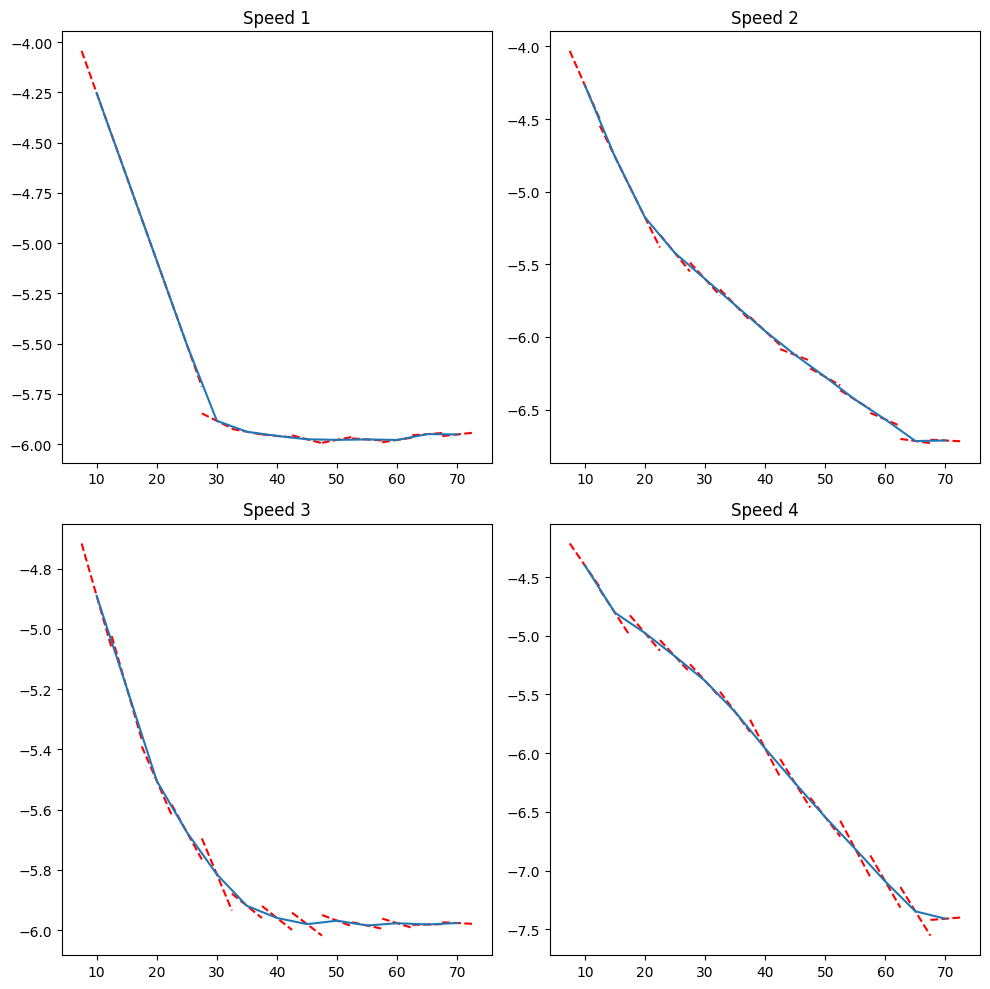

In [40]:
delta_inc = increment[1] - increment[0]
fig, axes = plt.subplots(2, 2, figsize=(10,10))

# Speed 1:
for inc, speed_obj, grad in zip(increment, speed_objectives_1, speed_grads_1):
    axes[0,0].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[0,0].plot(40+increment, [s.detach() for s in speed_objectives_1])
axes[0,0].set_title("Speed 1")

# Speed 2:
for inc, speed_obj, grad in zip(increment, speed_objectives_2, speed_grads_2):
    axes[0,1].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[0,1].plot(40+increment, [s.detach() for s in speed_objectives_2])
axes[0,1].set_title("Speed 2")

# Speed 3:
for inc, speed_obj, grad in zip(increment, speed_objectives_3, speed_grads_3):
    axes[1,0].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[1,0].plot(40+increment, [s.detach() for s in speed_objectives_3])
axes[1,0].set_title("Speed 3")

# Speed 4:
for inc, speed_obj, grad in zip(increment, speed_objectives_4, speed_grads_4):
    axes[1,1].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[1,1].plot(40+increment, [s.detach() for s in speed_objectives_4])
axes[1,1].set_title("Speed 4")

plt.tight_layout()
plt.show()

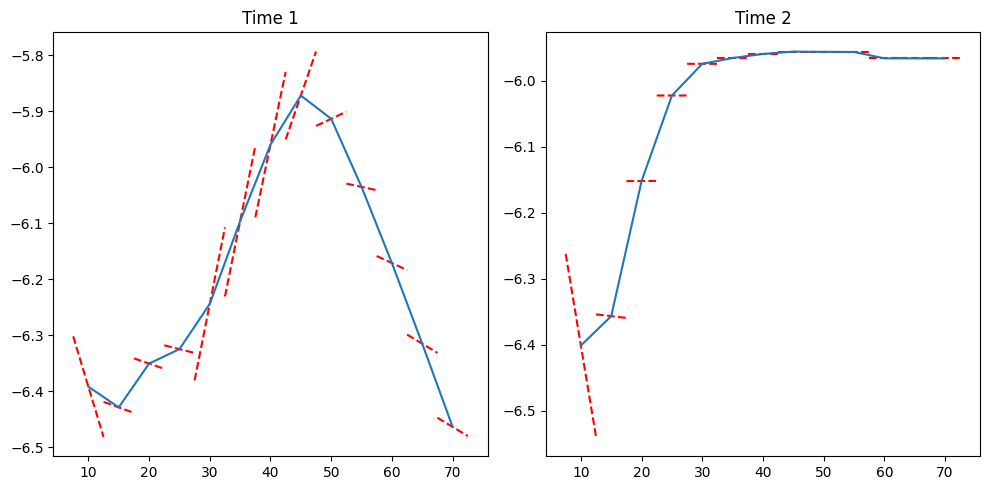

In [44]:
delta_inc = increment[1] - increment[0]
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Speed 1:
for inc, cycle_obj, grad in zip(increment, cycle_objectives_1, cycle_grads_1):
    axes[0].plot([60 + inc - delta_inc/2, 60 + inc + delta_inc/2], [cycle_obj.detach() - grad * delta_inc / 2, cycle_obj.detach() + grad * delta_inc / 2], '--r')
axes[0].plot(60+increment, [s.detach() for s in cycle_objectives_1])
axes[0].set_title("Time 1")

# Speed 2:
for inc, cycle_obj, grad in zip(increment, cycle_objectives_2, cycle_grads_2):
    axes[1].plot([60 + inc - delta_inc/2, 60 + inc + delta_inc/2], [cycle_obj.detach() - grad * delta_inc / 2, cycle_obj.detach() + grad * delta_inc / 2], '--r')
axes[1].plot(60+increment, [s.detach() for s in cycle_objectives_2])
axes[1].set_title("Time 2")


plt.tight_layout()
plt.show()

#### Zooming In

In [37]:
# Create network and run simulation
T = 150
N = 3
speed_limits = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
controls = [[], [], [], []]
cycle = [torch.tensor(60.0), torch.tensor(60.0)]

increment_2 =  np.linspace(-5, 5, 11)

In [45]:
speed_objectives_1_zoomed = []
speed_objectives_2_zoomed = []
speed_objectives_3_zoomed = []
speed_objectives_4_zoomed = []
cycle_objectives_1_zoomed = []
cycle_objectives_2_zoomed = []

speed_grads_1_zoomed = []
speed_grads_2_zoomed = []
speed_grads_3_zoomed = []
speed_grads_4_zoomed = []
cycle_grads_1_zoomed = []
cycle_grads_2_zoomed = []

for inc in tqdm(increment_2):
    with contextlib.redirect_stdout(None):
        speed_limits1 = [[torch.tensor(40.0 + inc)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
        speed_limits2 = [[torch.tensor(40.0)], [torch.tensor(40.0 + inc)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
        speed_limits3 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 + inc)], [torch.tensor(40.0)]]
        speed_limits4 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 + inc)]]

        cycle1 = [torch.tensor(60.0+inc), torch.tensor(60.0)]
        cycle2 = [torch.tensor(60.0), torch.tensor(60.0+inc)]

        speed_network_1 = generate.two_two_junction(T, N, speed_limits1, controls, cycle, track_grad=True)
        speed_network_2 = generate.two_two_junction(T, N, speed_limits2, controls, cycle, track_grad=True)
        speed_network_3 = generate.two_two_junction(T, N, speed_limits3, controls, cycle, track_grad=True)
        speed_network_4 = generate.two_two_junction(T, N, speed_limits4, controls, cycle, track_grad=True)
        cycle_network_1 = generate.two_two_junction(T, N, speed_limits, controls, cycle1, track_grad=True)
        cycle_network_2 = generate.two_two_junction(T, N, speed_limits, controls, cycle2, track_grad=True)

        densities_1, _, _, _, _ = speed_network_1.solve_cons_law_counting()
        densities_2, _, _, _, _ = speed_network_2.solve_cons_law_counting()
        densities_3, _, _, _, _ = speed_network_3.solve_cons_law_counting()
        densities_4, _, _, _, _ = speed_network_4.solve_cons_law_counting()
        densities_5, _, _, _, _ = cycle_network_1.solve_cons_law_counting()
        densities_6, _, _, _, _ = cycle_network_2.solve_cons_law_counting()

        throughput_1 = throughput(speed_network_1, densities_1)
        throughput_2 = throughput(speed_network_2, densities_2)
        throughput_3 = throughput(speed_network_3, densities_3)
        throughput_4 = throughput(speed_network_4, densities_4)
        throughput_5 = throughput(cycle_network_1, densities_5)
        throughput_6 = throughput(cycle_network_2, densities_6)

        speed_objectives_1_zoomed.append(throughput_1)
        speed_objectives_2_zoomed.append(throughput_2)
        speed_objectives_3_zoomed.append(throughput_3)
        speed_objectives_4_zoomed.append(throughput_4)
        cycle_objectives_1_zoomed.append(throughput_5)
        cycle_objectives_2_zoomed.append(throughput_6)

        grad_1 = get_throughput_grad(speed_network_1, throughput_1)
        grad_2 = get_throughput_grad(speed_network_2, throughput_2)
        grad_3 = get_throughput_grad(speed_network_3, throughput_3)
        grad_4 = get_throughput_grad(speed_network_4, throughput_4)
        grad_5 = get_throughput_grad(cycle_network_1, throughput_5)
        grad_6 = get_throughput_grad(cycle_network_2, throughput_6)

        speed_grads_1_zoomed.append(grad_1[0])
        speed_grads_2_zoomed.append(grad_2[1])
        speed_grads_3_zoomed.append(grad_3[2])
        speed_grads_4_zoomed.append(grad_4[3])
        cycle_grads_1_zoomed.append(grad_5[4])
        cycle_grads_2_zoomed.append(grad_6[5])



 91%|█████████ | 10/11 [09:46<00:58, 58.98s/it]

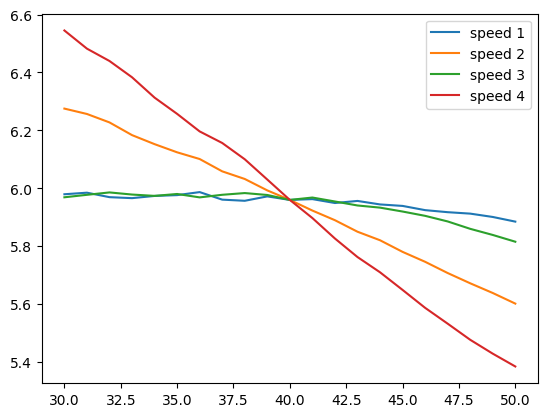

In [ ]:
delta_inc = increment_2[1] - increment_2[0]
fig, axes = plt.subplots(2, 2, figsize=(10,10))

# Speed 1:
for inc, speed_obj, grad in zip(increment_2, speed_objectives_1_zoomed, speed_grads_1_zoomed):
    axes[0,0].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[0,0].plot(40+increment_2, [s.detach() for s in speed_objectives_1_zoomed])
axes[0,0].set_title("Speed 1")

# Speed 2:
for inc, speed_obj, grad in zip(increment_2, speed_objectives_2_zoomed, speed_grads_2_zoomed):
    axes[0,1].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[0,1].plot(40+increment_2, [s.detach() for s in speed_objectives_2_zoomed])
axes[0,1].set_title("Speed 2")

# Speed 3:
for inc, speed_obj, grad in zip(increment_2, speed_objectives_3_zoomed, speed_grads_3_zoomed):
    axes[1,0].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[1,0].plot(40+increment_2, [s.detach() for s in speed_objectives_3_zoomed])
axes[1,0].set_title("Speed 3")

# Speed 4:
for inc, speed_obj, grad in zip(increment_2, speed_objectives_4_zoomed, speed_grads_4_zoomed):
    axes[1,1].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[1,1].plot(40+increment_2, [s.detach() for s in speed_objectives_4_zoomed])
axes[1,1].set_title("Speed 4")

plt.tight_layout()
plt.show()

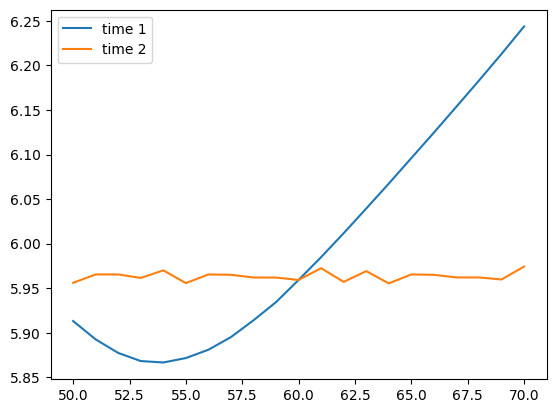

In [12]:
delta_inc = increment_2[1] - increment_2[0]
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Speed 1:
for inc, cycle_obj, grad in zip(increment_2, cycle_objectives_1_zoomed, cycle_grads_1_zoomed):
    axes[0].plot([60 + inc - delta_inc/2, 60 + inc + delta_inc/2], [cycle_obj.detach() - grad * delta_inc / 2, cycle_obj.detach() + grad * delta_inc / 2], '--r')
axes[0].plot(40+increment_2, [s.detach() for s in cycle_objectives_1_zoomed])
axes[0].set_title("Time 1")

# Speed 2:
for inc, cycle_obj, grad in zip(increment_2, cycle_objectives_2_zoomed, cycle_grads_2_zoomed):
    axes[1].plot([60 + inc - delta_inc/2, 60 + inc + delta_inc/2], [cycle_obj.detach() - grad * delta_inc / 2, cycle_obj.detach() + grad * delta_inc / 2], '--r')
axes[1].plot(60+increment_2, [s.detach() for s in cycle_objectives_2_zoomed])
axes[1].set_title("Time 2")


plt.tight_layout()
plt.show()

#### Final Zoom

In [ ]:
# Create network and run simulation
T = 150
N = 3
speed_limits = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
controls = [[], [], [], []]
cycle = [torch.tensor(60.0), torch.tensor(60.0)]

increment_3 =  np.linspace(-1, 1, 11)

In [ ]:
speed_objectives_1_zoomed_2 = []
speed_objectives_2_zoomed_2 = []
speed_objectives_3_zoomed_2 = []
speed_objectives_4_zoomed_2 = []
cycle_objectives_1_zoomed_2 = []
cycle_objectives_2_zoomed_2 = []

speed_grads_1_zoomed_2 = []
speed_grads_2_zoomed_2 = []
speed_grads_3_zoomed_2 = []
speed_grads_4_zoomed_2 = []
cycle_grads_1_zoomed_2 = []
cycle_grads_2_zoomed_2 = []

for inc in tqdm(increment_3):
    with contextlib.redirect_stdout(None):
        speed_limits1 = [[torch.tensor(40.0 + inc)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
        speed_limits2 = [[torch.tensor(40.0)], [torch.tensor(40.0 + inc)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
        speed_limits3 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 + inc)], [torch.tensor(40.0)]]
        speed_limits4 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 + inc)]]

        cycle1 = [torch.tensor(60.0+inc), torch.tensor(60.0)]
        cycle2 = [torch.tensor(60.0), torch.tensor(60.0+inc)]

        speed_network_1 = generate.two_two_junction(T, N, speed_limits1, controls, cycle, track_grad=True)
        speed_network_2 = generate.two_two_junction(T, N, speed_limits2, controls, cycle, track_grad=True)
        speed_network_3 = generate.two_two_junction(T, N, speed_limits3, controls, cycle, track_grad=True)
        speed_network_4 = generate.two_two_junction(T, N, speed_limits4, controls, cycle, track_grad=True)
        cycle_network_1 = generate.two_two_junction(T, N, speed_limits, controls, cycle1, track_grad=True)
        cycle_network_2 = generate.two_two_junction(T, N, speed_limits, controls, cycle2, track_grad=True)

        densities_1, _, _, _, _ = speed_network_1.solve_cons_law_counting()
        densities_2, _, _, _, _ = speed_network_2.solve_cons_law_counting()
        densities_3, _, _, _, _ = speed_network_3.solve_cons_law_counting()
        densities_4, _, _, _, _ = speed_network_4.solve_cons_law_counting()
        densities_5, _, _, _, _ = cycle_network_1.solve_cons_law_counting()
        densities_6, _, _, _, _ = cycle_network_2.solve_cons_law_counting()

        throughput_1 = throughput(speed_network_1, densities_1)
        throughput_2 = throughput(speed_network_2, densities_2)
        throughput_3 = throughput(speed_network_3, densities_3)
        throughput_4 = throughput(speed_network_4, densities_4)
        throughput_5 = throughput(cycle_network_1, densities_5)
        throughput_6 = throughput(cycle_network_2, densities_6)

        speed_objectives_1_zoomed_2.append(throughput_1)
        speed_objectives_2_zoomed_2.append(throughput_2)
        speed_objectives_3_zoomed_2.append(throughput_3)
        speed_objectives_4_zoomed_2.append(throughput_4)
        cycle_objectives_1_zoomed_2.append(throughput_5)
        cycle_objectives_2_zoomed_2.append(throughput_6)

        grad_1 = get_throughput_grad(speed_network_1, throughput_1)
        grad_2 = get_throughput_grad(speed_network_2, throughput_2)
        grad_3 = get_throughput_grad(speed_network_3, throughput_3)
        grad_4 = get_throughput_grad(speed_network_4, throughput_4)
        grad_5 = get_throughput_grad(cycle_network_1, throughput_5)
        grad_6 = get_throughput_grad(cycle_network_2, throughput_6)

        speed_grads_1_zoomed_2.append(grad_1[0])
        speed_grads_2_zoomed_2.append(grad_2[1])
        speed_grads_3_zoomed_2.append(grad_3[2])
        speed_grads_4_zoomed_2.append(grad_4[3])
        cycle_grads_1_zoomed_2.append(grad_5[4])
        cycle_grads_2_zoomed_2.append(grad_6[5])



Bus bus_1 reached bus stop 0 at time 30.571428298950195, should wait for 29.395183034977165 seconds
Bus bus_2 reached bus stop 0 at time 104.71428525447845, should wait for 29.555442408059424 seconds
Bus bus_1 reached bus stop 0 at time 30.571428298950195, should wait for 29.487785220989263 seconds
Bus bus_2 reached bus stop 0 at time 104.71428525447845, should wait for 29.555442476030915 seconds
Bus bus_1 reached bus stop 0 at time 30.057141661643982, should wait for 29.597569995891238 seconds
Bus bus_2 reached bus stop 0 at time 102.5852735042572, should wait for 29.537151813844137 seconds
Bus bus_1 reached bus stop 0 at time 29.928571164608, should wait for 29.702920998661163 seconds
Bus bus_2 reached bus stop 0 at time 105.35714238882065, should wait for 29.455934455153738 seconds
Bus bus_1 reached bus stop 0 at time 29.928571164608, should wait for 29.707948367042782 seconds
Bus bus_2 reached bus stop 0 at time 103.71428525447845, should wait for 29.55544081356504 seconds
Bus bus_

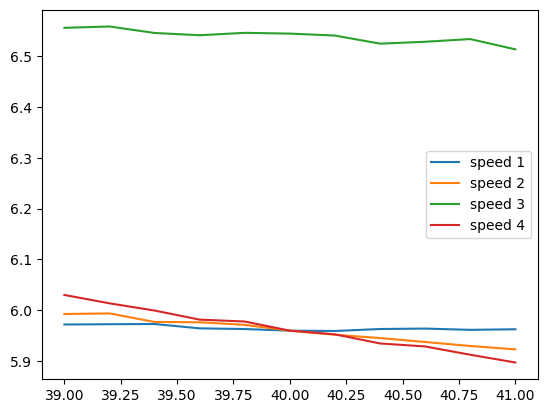

In [15]:
delta_inc = increment_3[1] - increment_3[0]
fig, axes = plt.subplots(2, 2, figsize=(10,10))

# Speed 1:
for inc, speed_obj, grad in zip(increment_3, speed_objectives_1_zoomed_2, speed_grads_1_zoomed_2):
    axes[0,0].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[0,0].plot(40+increment_3, [s.detach() for s in speed_objectives_1_zoomed_2])
axes[0,0].set_title("Speed 1")

# Speed 2:
for inc, speed_obj, grad in zip(increment_3, speed_objectives_2_zoomed_2, speed_grads_2_zoomed_2):
    axes[0,1].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[0,1].plot(40+increment_3, [s.detach() for s in speed_objectives_2_zoomed_2])
axes[0,1].set_title("Speed 2")

# Speed 3:
for inc, speed_obj, grad in zip(increment_3, speed_objectives_3_zoomed_2, speed_grads_3_zoomed_2):
    axes[1,0].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[1,0].plot(40+increment_3, [s.detach() for s in speed_objectives_3_zoomed_2])
axes[1,0].set_title("Speed 3")

# Speed 4:
for inc, speed_obj, grad in zip(increment_3, speed_objectives_4_zoomed_2, speed_grads_4_zoomed_2):
    axes[1,1].plot([40 + inc - delta_inc/2, 40 + inc + delta_inc/2], [speed_obj.detach() - grad * delta_inc / 2, speed_obj.detach() + grad * delta_inc / 2], '--r')
axes[1,1].plot(40+increment_3, [s.detach() for s in speed_objectives_4_zoomed_2])
axes[1,1].set_title("Speed 4")

plt.tight_layout()
plt.show()

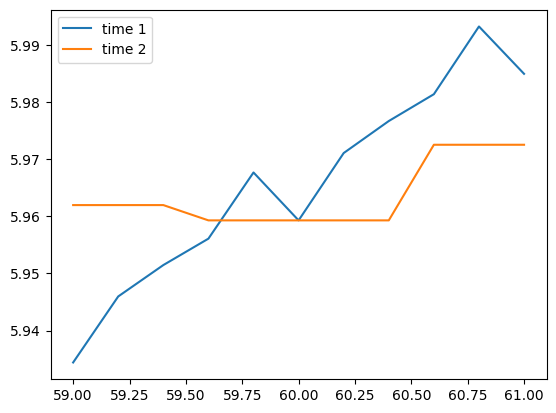

In [16]:
delta_inc = increment_3[1] - increment_3[0]
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Speed 1:
for inc, cycle_obj, grad in zip(increment_3, cycle_objectives_1_zoomed_2, cycle_grads_1_zoomed_2):
    axes[0].plot([60 + inc - delta_inc/2, 60 + inc + delta_inc/2], [cycle_obj.detach() - grad * delta_inc / 2, cycle_obj.detach() + grad * delta_inc / 2], '--r')
axes[0].plot(40+increment_3, [s.detach() for s in cycle_objectives_1_zoomed_2])
axes[0].set_title("Time 1")

# Speed 2:
for inc, cycle_obj, grad in zip(increment_3, cycle_objectives_2_zoomed_2, cycle_grads_2_zoomed_2):
    axes[1].plot([60 + inc - delta_inc/2, 60 + inc + delta_inc/2], [cycle_obj.detach() - grad * delta_inc / 2, cycle_obj.detach() + grad * delta_inc / 2], '--r')
axes[1].plot(60+increment_3, [s.detach() for s in cycle_objectives_2_zoomed_2])
axes[1].set_title("Time 2")


plt.tight_layout()
plt.show()